#**Bankruptcy Prediction Using Financial Metrics**
*IE 7275 Data Mining in Engineering*

###**Mahrukh Malik**
###**Sonali Godade**
###**Sumanth Wannur**

In [83]:
#installing required packages
!pip install optuna
!pip install linearmodels

##**Importing Libraries**

In [155]:
import pandas as pd
import numpy as np
import optuna
import os
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
from optuna.integration import OptunaSearchCV as OSC
from IPython.display import display, Markdown
import math
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.utils import resample
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.cov_struct import Independence
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
import xgboost as xgb

##**Uploading Data**

In [84]:
#loading data from google drive
drive_file_id = '1u7_RkgyY7LIA1zvArUq2YIraSmh0Gs6p'
drive_file_url = f'https://drive.google.com/uc?id={drive_file_id}'
data = pd.read_csv(drive_file_url)

#displaying data
display(data.head())

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999.0,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000.0,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001.0,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002.0,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003.0,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


##**Cleaning Data**

In [85]:
#displaying dtypes of columns
data.dtypes

company_name     object
status_label     object
year            float64
X1              float64
X2              float64
X3              float64
X4              float64
X5              float64
X6              float64
X7              float64
X8              float64
X9              float64
X10             float64
X11             float64
X12             float64
X13             float64
X14             float64
X15             float64
X16             float64
X17             float64
X18             float64
dtype: object

In [86]:
#checking for missing values
data_na = data.isnull().sum()
data_na

company_name    0
status_label    0
year            0
X1              0
X2              0
X3              0
X4              0
X5              0
X6              0
X7              0
X8              0
X9              0
X10             0
X11             0
X12             0
X13             0
X14             0
X15             0
X16             0
X17             0
X18             0
dtype: int64

In [87]:
#checking the length of dataset
len(data)

78682

In [88]:
#getting the summary of all variables
display(data.describe(include='all'))

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
count,78682,78682,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,...,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000
unique,8971,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,C_4081,alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,20,73462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2007.506317,880.362485,1594.529029,121.234256,376.759424,201.605717,129.382453,286.832743,...,2364.019706,2867.110620,722.483710,255.525035,769.490783,610.072255,532.467069,2364.019706,1773.563963,1987.260307
std,NaN,NaN,5.742768,3928.564794,8930.484664,652.376804,2012.023142,1060.766096,1265.532022,1335.978571,...,11950.068842,12917.944421,3242.170946,1494.643534,3774.703114,2938.387443,6369.159440,11950.068842,8053.684902,10419.629038
min,NaN,NaN,1999.000000,-7.760000,-366.645000,0.000000,-21913.000000,0.000000,-98696.000000,-0.006000,...,-1964.999000,0.001000,-0.023000,-25913.000000,-21536.000000,0.001000,-102362.000000,-1964.999000,0.001000,-317.197000
25%,NaN,NaN,2002.000000,18.924000,17.038250,1.192000,-0.811000,0.000000,-7.415750,3.281250,...,27.548500,37.363500,0.000000,-2.787000,8.521250,8.889250,-68.282750,27.548500,13.486000,32.872500
50%,NaN,NaN,2007.000000,100.449500,103.661000,7.929500,15.034500,7.023000,1.616000,22.820000,...,186.598500,213.203500,7.593500,6.518000,63.581500,43.333000,-1.131000,186.598500,81.988000,168.912000
75%,NaN,NaN,2012.000000,431.526750,634.548000,47.971750,139.655250,74.747250,40.144250,131.580500,...,1046.402500,1171.364750,248.760750,87.599000,344.074250,222.817000,146.070000,1046.402500,629.975000,875.522250


In [89]:
#renaming columns
data = data.rename(columns={'X1':'current_assets','X2':'COGS','X3':'depr_and_amort','X4':'EBITDA','X5':'inventory','X6':'net_income',
                            'X7':'total_receivables','X8':'market_value','X9':'net_sales','X10':'total_assets','X11':'total_long_term_debt',
                            'X12':'EBIT','X13':'gross_profit','X14':'total_current_liabilities','X15':'retained_earnings','X16':'total_revenue',
                            'X17':'total_liabilities','X18':'total_operating_expenses'})

In [90]:
list(data.columns)

['company_name',
 'status_label',
 'year',
 'current_assets',
 'COGS',
 'depr_and_amort',
 'EBITDA',
 'inventory',
 'net_income',
 'total_receivables',
 'market_value',
 'net_sales',
 'total_assets',
 'total_long_term_debt',
 'EBIT',
 'gross_profit',
 'total_current_liabilities',
 'retained_earnings',
 'total_revenue',
 'total_liabilities',
 'total_operating_expenses']

##**Exploratory Data Analysis**

In [91]:
#binerization of target variable
data['status_label'] = data['status_label'].map({'alive': 0, 'failed': 1})

###**Plotting Data**

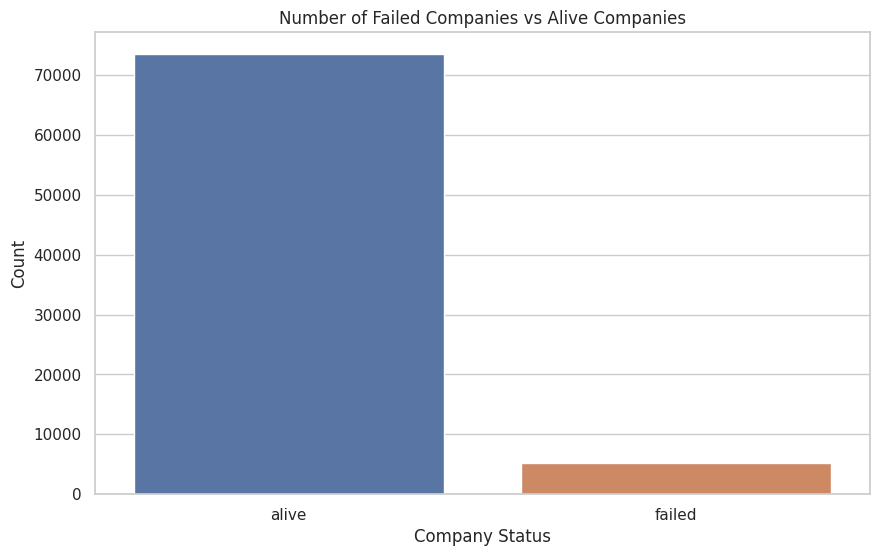

In [92]:
#checking distribution of failed companies vs alive companies
sns.set(style="whitegrid")
status_counts = data['status_label'].value_counts()
status_labels = ["alive", "failed"]
plt.figure(figsize=(10, 6))
sns.barplot(x=status_labels, y=status_counts)
plt.title('Number of Failed Companies vs Alive Companies')
plt.ylabel('Count')
plt.xlabel('Company Status')

plt.show()

From this graph, we can see that there is a significant class imbalance in our dataset, with a much larger number of alive companies compared to failed ones. This imbalance indicates that the minority class (failed companies) is underrepresented. This presents a challenge for predictive modeling, as it can lead to a bias towards the majority class and potentially reduce the accuracy of predictions for the minority class.

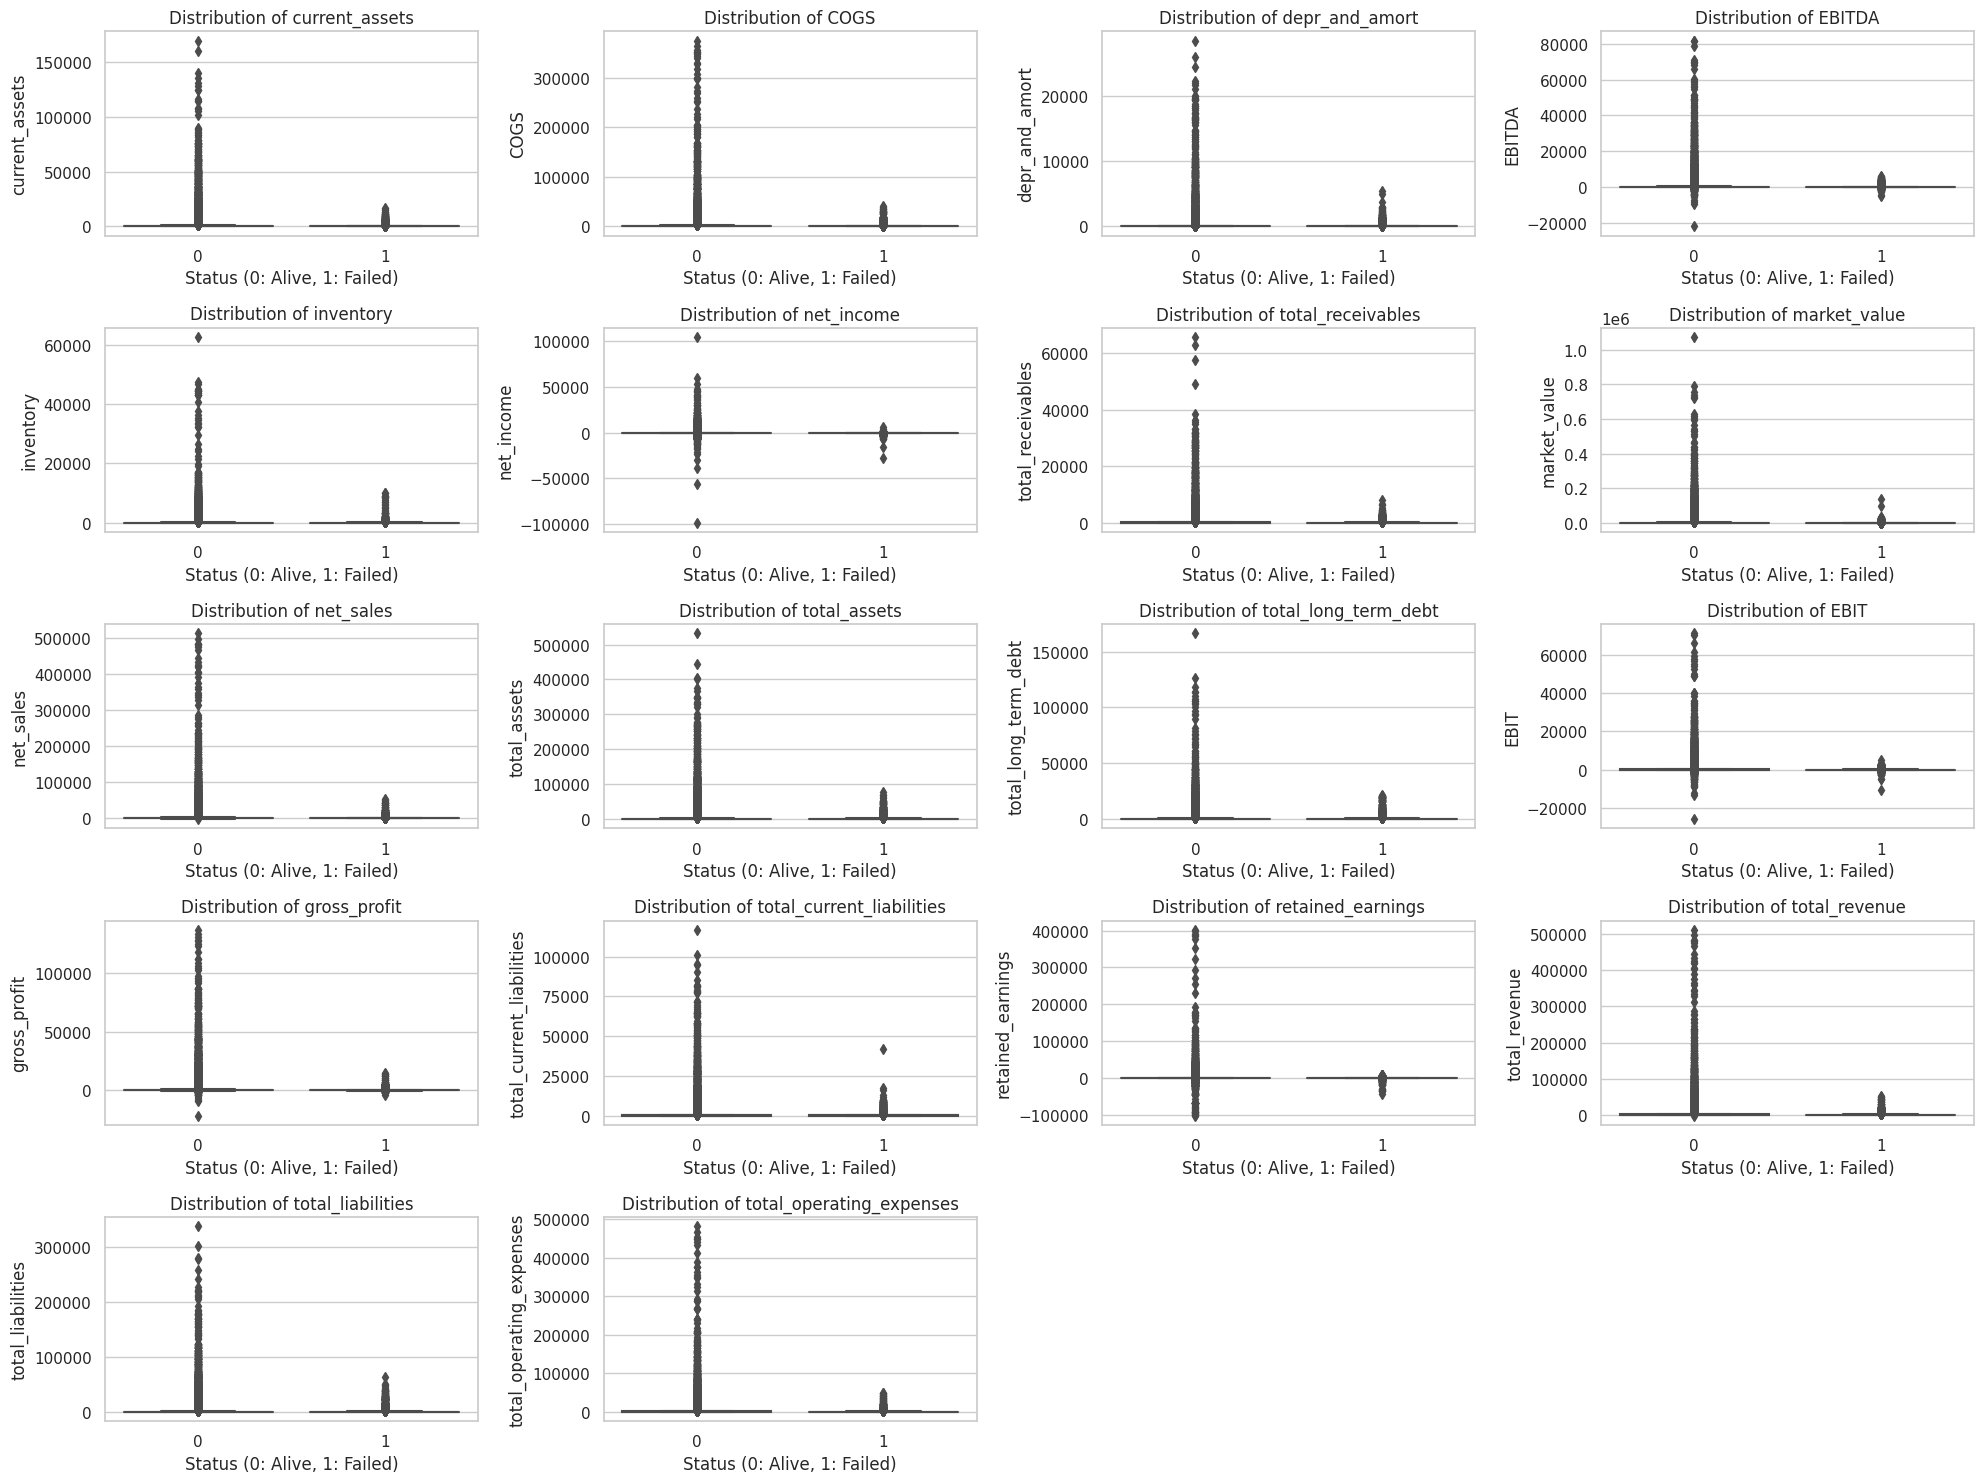

In [93]:
#features Distribution in Alive and Failed Companies
selected_features = list(data.columns)[3:]
num_features = len(selected_features)
cols = 4
rows = math.ceil(num_features / cols)

plt.figure(figsize=(20, 15))

for i, feature in enumerate(selected_features, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x='status_label', y=feature, data=data)
    plt.title(f'Distribution of {feature}')
    plt.xlabel('Status (0: Alive, 1: Failed)')


plt.tight_layout()
plt.show()


The set of charts provided displays the distribution of various financial features based on the status label, where '1' represents failed companies and '0' represents alive companies. Across all features, we can observe an overlap in the data points for both classes.

For example, the range of current assets for failed companies (Status 1) falls entirely within the range of current assets for alive companies (Status 0). Specifically, the overlap occurs in the lower range of current assets. Since all the data points for failed companies (Status 1) are also covered by the spread of points for alive companies (Status 0), the overlap is in the entire range of current assets values represented by failed companies.

This may be attributed to the ground reality that even though a company is not going bankrupt, it may still be undergoing financial distress or events like leveraged buyouts, restructuring, or significant shifts in market conditions that affect its financial metrics similarly to a failing company.

Financial distress can significantly reduce a company's liquidity and current assets, even if it does not lead to bankruptcy. For instance, a company engaged in a leveraged buyout might take on substantial debt, reducing its net current assets. Such scenarios can cause the financial profiles of distressed but still 'alive' companies to resemble those of companies that are actually going bankrupt, leading to the observed overlap in the distribution of current assets between the two groups.

This overlap suggests that for any given financial metric, there are both alive and failed companies with similar values, making it challenging to distinguish between the two. Consequently, this could complicate the task of building a predictive model, as it would require more sophisticated techniques or additional features to effectively separate the classes and accurately predict the likelihood of a company going bankrupt.

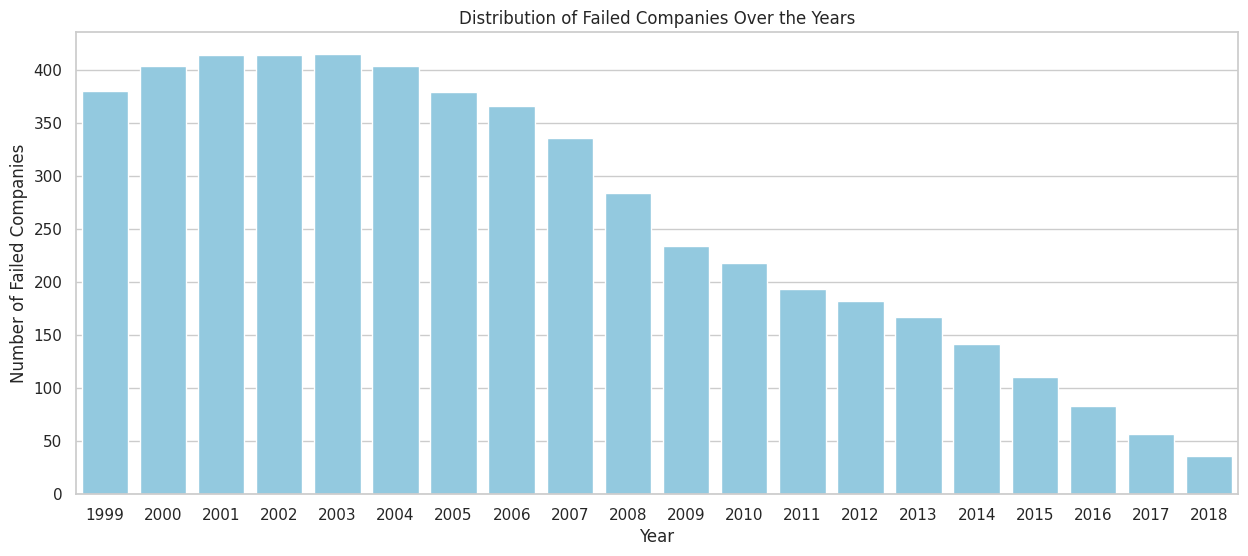

In [94]:
#distribution of failed companies over the years
failed_companies_by_year = data[data['status_label'] == 1]['year'].value_counts().sort_index()

plt.figure(figsize=(15, 6))
sns.barplot(x=failed_companies_by_year.index.astype(int), y=failed_companies_by_year.values, color='skyblue')
plt.title('Distribution of Failed Companies Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Failed Companies')

plt.show()


The graph indicates a notable decrease in the number of company bankruptcies after the 2007 financial crisis. This decline could be due to stricter financial regulations and more cautious business practices. As a result, bankruptcies have become more infrequent, exacerbating the class imbalance in the data, particularly in the years following the crisis. This makes it challenging for predictive models to learn from a dwindling number of failure cases, potentially affecting their accuracy in forecasting future bankruptcies.

##**Data Preprocessing and Feature Engnineering**

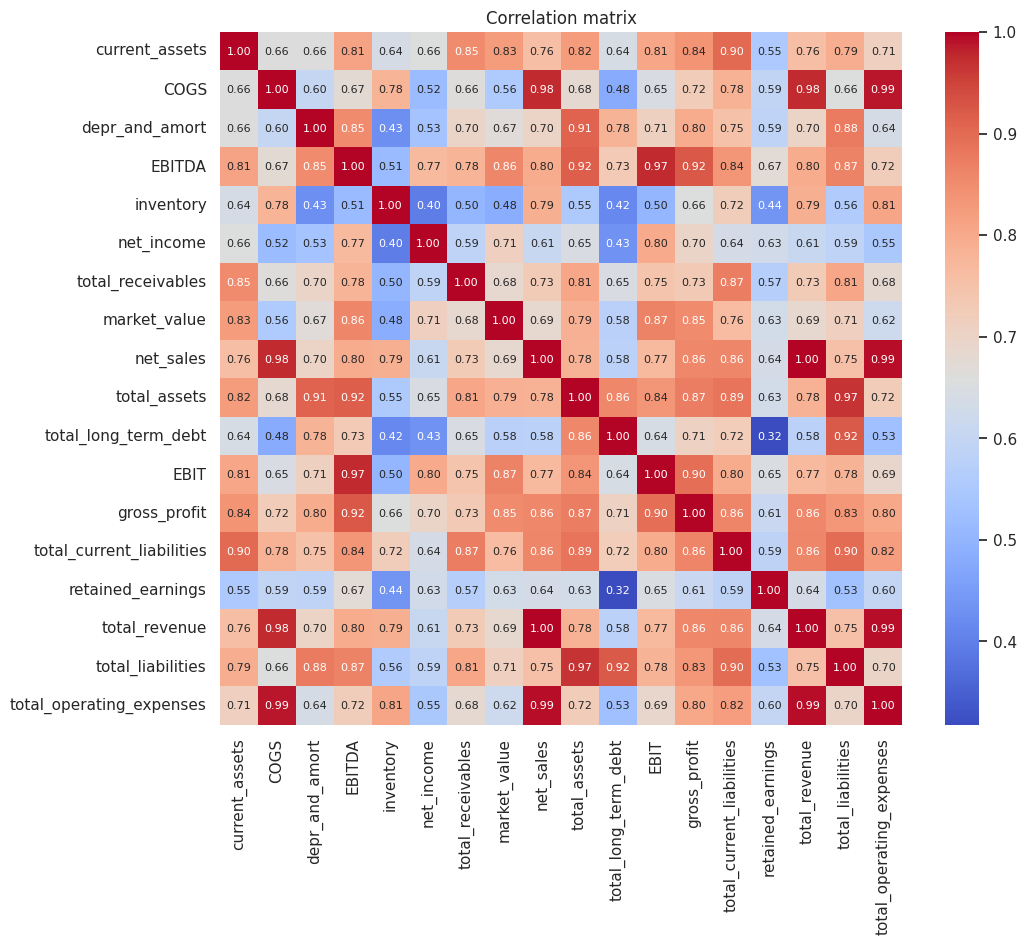

In [95]:
#correlation matrix
column_names = list(data.columns)[3:]
plt.figure(figsize=(11, 9))
sns.heatmap(data[column_names].corr(), annot=True, cmap='coolwarm', fmt=".2f",
            annot_kws={"size": 8})
plt.title('Correlation matrix')
plt.show()

The matrix demonstrates strong positive correlations between many of the financial variables. Such high correlations are common in financial data due to the interconnected nature of financial statements where certain variables are intrinsically related (like sales and revenue, or assets and liabilities).

The presence of strong correlations close to 1 suggest multicollinearity, which can be a concern when building regression models. We can consider methods to handle multicollinearity, such as principal component analysis (PCA) and feature downsizing.

###**Feature Downsizing**

net_sales and total_revenue are effectively the same and thus exhibit perfect correlation (1.00). To reduce multicollinearity, one of them will be removed from the analysis.

In [96]:
data = data.drop("total_revenue", axis=1)


Net sales and COGS are closely linked. Since gross profit is net sales minus COGS, it reflects the necessary information from both. Moreover, as COGS is included in total operating expenses, its removal along with net sales does not result in information loss. To reduce multicollinearity, we will exclude net sales and COGS, retaining gross profit and total operating expenses for a clearer analysis.

In [97]:
data = data.drop("net_sales", axis=1)
data = data.drop("COGS", axis=1)

"EBITDA" and "EBIT" show a high degree of correlation since "depr_and_amort" is the only differentiator, defined as EBITDA - EBIT = depr_and_amort. Therefore, to lower multicollinearity, EBITDA can be omitted from the dataset as that information is present in EBIT and depr_and_amort.

In [98]:
data = data.drop("EBITDA", axis=1)

Since "gross_profit" is EBIT + depr_and_amort + total_operating_expenses, it is redundant and can be removed from the dataset.

In [99]:
data = data.drop("gross_profit", axis=1)

"total_assets" and "total_liabilities" are highly correlated. Since equity = assets - liabilities, this correlation might reflect similar equity ratios across companies. It's not clear if either should be removed, but we can combine their information into a single variable by calculating the ratio of assets to liabilities.

In [100]:
data['TLTA'] = data['total_liabilities']/data['total_assets']
data = data.drop("total_liabilities", axis=1)
data = data.drop("total_assets", axis=1)

In [101]:
data['CLCA'] = data['total_current_liabilities']/data['current_assets']
data = data.drop("total_current_liabilities", axis=1)
data = data.drop("current_assets", axis=1)

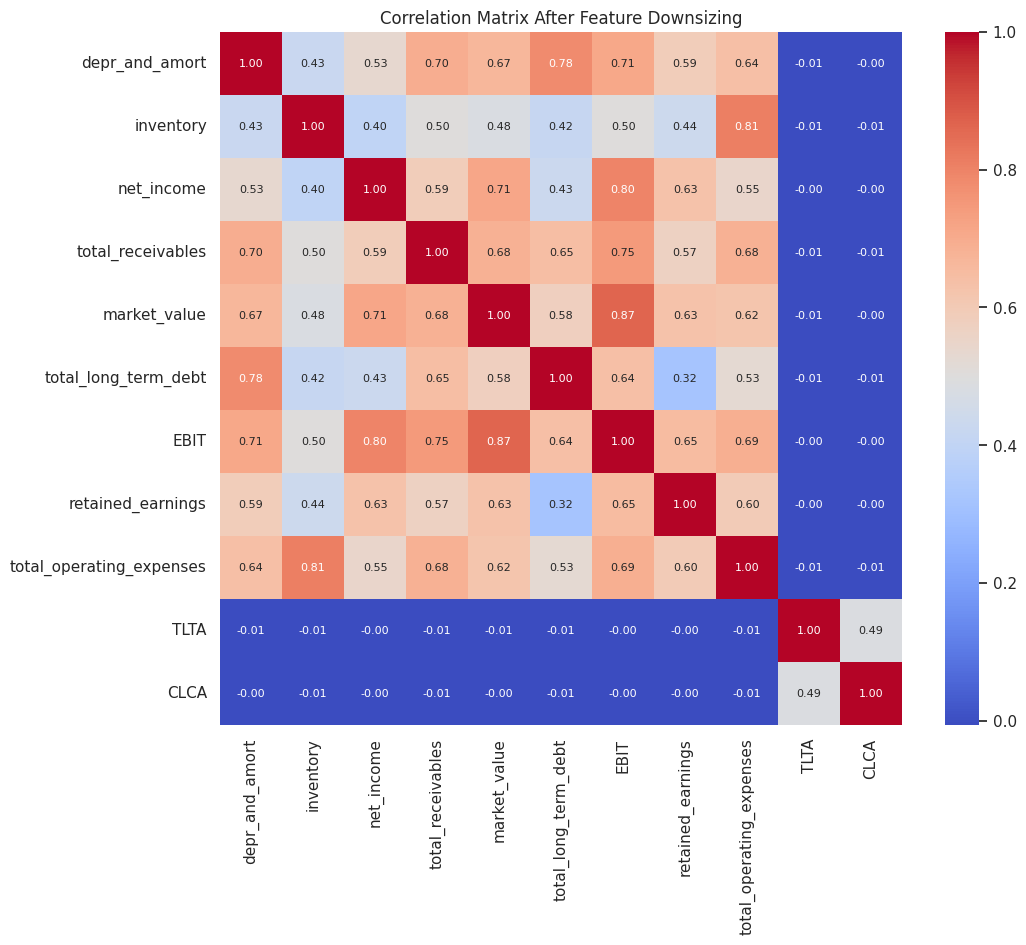

In [102]:
#correlation matrix after feature downsizing
column_names = list(data.columns)[3:]
plt.figure(figsize=(11, 9))
sns.heatmap(data[column_names].corr(), annot=True, cmap='coolwarm', fmt=".2f",
            annot_kws={"size": 8})
plt.title('Correlation Matrix After Feature Downsizing')
plt.show()

The updated correlation matrix after feature downsizing shows that the previous high correlations between certain variables have been reduced significantly.

In [103]:
VIF_dataframe = pd.DataFrame()
VIF_dataframe["feature"] = data[column_names].columns
VIF_dataframe["VIF"] = [variance_inflation_factor(data[column_names].values, i) for i in range(len(data[column_names].columns))]
VIF_dataframe

,feature,VIF
0,depr_and_amort,4.449506
1,inventory,3.269976
2,net_income,3.036380
3,total_receivables,3.043303
4,market_value,4.401078
5,total_long_term_debt,3.625241
6,EBIT,7.442140
7,retained_earnings,2.520678
8,total_operating_expenses,5.264978
9,TLTA,1.312795


Since the VIF < 10 for all variables now, we have reduced a lot of multicollinearity.

##**Preparing Datasets**

Panel data is a dataset that contains observations on a set of entities—such as individuals, organizations, or countries, across time. Our data qualifies as panel data because it tracks various financial metrics for a set of companies over several years.

Standard regression models typically assume that each observation is independent of the others. However, in panel data, observations for the same entity are likely to be correlated over time, violating this assumption. This is why panel data cannot be directly used in classical regression models without adjustments to allow for cross-sectional analysis (where each sample is considered independant)

To analyze such panel data effectively, we employ three different techniques, each offering a unique lens:

1. **Using Lagged Values:** By analyzing the data in its original form, we can observe how each company's metrics evolve over time, thus maintaining the integrity of the temporal information.

2. **Handling as Panel Data:** It leverages the data's longitudinal structure to examine temporal trends and the evolution of financial health over time.

3. **Cross-sectional Snapshots:** We take a specific time slice of data for each company, effectively treating each company's selected observation as independent. Simplifying the data to one year observation per company allows us to focus on specific years, particularly important in contrasting the conditions between companies that failed and those that did not at a particular time.

###**Dataset 1 - Using Lagged Values**

Company-year as separate sample with lag values

In [104]:
column_names = list(data.columns)
column_names = column_names[3:]

#creating lag features for financial metrics (lag of 2 year)
dataset1 = data.copy()
for col in column_names:
    dataset1[col + '_lag2'] = dataset1.groupby('company_name')[col].shift(2)

lagged_columns = [col for col in dataset1.columns if '_lag2' in col or col in ['company_name', 'year', 'status_label']]
dataset1 = dataset1[lagged_columns]

#removing rows with NaN values created due to lag
dataset1.dropna(inplace=True)

<ipython-input-104-197996ab25c8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1.dropna(inplace=True)


###**Dataset 2 - Handling as Panel Data**

Handling as panel data. For panel data, the structure remains the same but will be treated differently in the modeling phase

In [105]:
dataset2 = data.copy()

###**Dataset 3- Cross-sectional Snapshots**

1. For failed companies, get the data 2 years prior to the last year
2. For alive companies, randomly select a year where 2 years prior data is available

In [106]:
#failed companies
failed_companies = data[data['status_label'] == 1]['company_name'].unique()
data_failed_list = []
for company in failed_companies:
    last_year = data[(data['company_name'] == company) & (data['status_label'] == 1)]['year'].max()
    data_failed_list.append(data[(data['company_name'] == company) & (data['year'] == last_year - 2)])

data_failed = pd.concat(data_failed_list, ignore_index=True)

#alive companies
alive_companies = data[data['status_label'] == 0]['company_name'].unique()
data_alive_list = []
for company in alive_companies:
    available_years = data[(data['company_name'] == company) & (data['status_label'] == 0)]['year'].unique()
    available_years = [year for year in available_years if year - 2 in available_years]
    if available_years:
        random.seed(42)
        selected_year = random.choice(available_years)
        data_alive_list.append(data[(data['company_name'] == company) & (data['year'] == selected_year)])

data_alive = pd.concat(data_alive_list, ignore_index=True)

#combining failed and alive companies
dataset3 = pd.concat([data_failed, data_alive], ignore_index=True)


##**Temporal train-test Splitting**
Training set includes data until the year 2014, and test set includes data from 2015 onwards

In [107]:
#splitting for Dataset 1
train_dataset1 = dataset1[dataset1['year'] <= 2014]
test_dataset1 = dataset1[dataset1['year'] > 2014]

#splitting for Dataset 2
train_dataset2 = dataset2[dataset2['year'] <= 2014]
test_dataset2 = dataset2[dataset2['year'] > 2014]

#splitting for Dataset 3
train_dataset3 = dataset3[dataset3['year'] <= 2014]
test_dataset3 = dataset3[dataset3['year'] > 2014]

#displaying shapes
(train_dataset1.shape, test_dataset1.shape), (train_dataset2.shape, test_dataset2.shape), (train_dataset3.shape, test_dataset3.shape)


(((50298, 14), (11197, 14)),
 ((66400, 14), (12282, 14)),
 ((6098, 14), (1196, 14)))

##**Balancing Data**

In [108]:
#creating a function to balance the data
def balance_data(data):
    #separating majority and minority classes
    data_majority = data[data.status_label == 0]
    data_minority = data[data.status_label == 1]

    #downsampling majority class
    data_majority_downsampled = resample(data_majority,
                                         replace=False,
                                         n_samples=len(data_minority),
                                         random_state=123)

    return pd.concat([data_majority_downsampled, data_minority])

#balancing dataset 1
train_dataset1 = balance_data(train_dataset1)

#balancing dataset 2
minority_count = train_dataset2[train_dataset2['status_label'] == 1].shape[0]
majority_downsampled = resample(train_dataset2[train_dataset2['status_label'] == 0],
                                replace=False,
                                n_samples=minority_count,
                                random_state=123)
train_dataset2 = pd.concat([majority_downsampled, train_dataset2[train_dataset2['status_label'] == 1]])

#balancing dataset 3
train_dataset3 = balance_data(train_dataset3)

print(train_dataset1.shape, train_dataset2.shape, train_dataset3.shape)

(7480, 14) (9866, 14) (1022, 14)


##**Running Models on Dataset2**

###**Standardizing Data**

In [109]:
#defining function to standardize data
def standardizing_data_for_modeling(train_dataset, test_dataset):
    cols_to_exclude = ['status_label', 'company_name', 'year']
    cols_to_standardize = train_dataset.columns.difference(cols_to_exclude)

    scaler = StandardScaler()
    train_dataset[cols_to_standardize] = scaler.fit_transform(train_dataset[cols_to_standardize])
    test_dataset[cols_to_standardize] = scaler.transform(test_dataset[cols_to_standardize])
    print("Shapes after scaling:")
    print(train_dataset[cols_to_standardize].shape)
    print(test_dataset[cols_to_standardize].shape)

    print("Shapes before dropping columns:")
    print(train_dataset.shape)
    print(test_dataset.shape)

    y_train = train_dataset['status_label']
    X_train = train_dataset.drop(['status_label', 'company_name', 'year'], axis=1)
    y_test = test_dataset['status_label']
    X_test = test_dataset.drop(['status_label', 'company_name', 'year'], axis=1)

    print("Shapes after splitting into X and y:")
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

    return X_train, y_train, X_test, y_test

###**GEE Method**

In [72]:
#company_name is used as the group variable
groups = train_dataset2['company_name']

#standardizing data
gee_train_dataset2 = train_dataset2.copy()
gee_test_dataset2 = test_dataset2.copy()
gee_X_train, gee_y_train, gee_X_test, gee_y_test = standardizing_data_for_modeling(gee_train_dataset2, gee_test_dataset2)

gee_X_train = sm.add_constant(gee_X_train)

#defining and fitting GEE model
gee_model = GEE(gee_y_train, gee_X_train, groups=groups, family=sm.families.Binomial(), cov_struct=Independence())
gee_results = gee_model.fit()

print(gee_results.summary())


Shapes after scaling:
(9866, 11)
(12282, 11)
Shapes before dropping columns:
(9866, 14)
(12282, 14)
Shapes after splitting into X and y:
(9866, 11) (9866,)
(12282, 11) (12282,)
                               GEE Regression Results                              
Dep. Variable:                status_label   No. Observations:                 9866
Model:                                 GEE   No. clusters:                     4029
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                  16
Family:                           Binomial   Mean cluster size:                 2.4
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Fri, 15 Dec 2023   Scale:                           1.000
Covariance type:                    robust   Time:                         13:16:22
                               coef    std err          z      P>|z

In [73]:
gee_X_test = sm.add_constant(gee_X_test)

#using class counts offset to account for the class imbalance
class_counts = train_dataset2['status_label'].value_counts()

#getting the predicted probabilities
gee_predicted_probs = gee_results.predict(gee_X_test, offset=np.log(class_counts[0] / class_counts[1]))
threshold = 0.52
gee_predicted_classes = (gee_predicted_probs > threshold).astype(int)

#evaluating model
gee_cm = confusion_matrix(gee_y_test, gee_predicted_classes)
TN, FP, FN, TP = gee_cm.ravel()
gee_accuracy = (TP + TN) / (TP + TN + FP + FN) * 100
gee_recall = TP / (TP + FN) * 100
gee_cm_df = pd.DataFrame(gee_cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

print("Accuracy: {:.2f}%".format(gee_accuracy))
print("Recall: {:.2f}%".format(gee_recall))
print("\n")
print(gee_cm_df)

Accuracy: 83.89%
Recall: 68.29%


                 Predicted Negative  Predicted Positive
Actual Negative               10107                1888
Actual Positive                  91                 196


###**Gradient Boosting Machines (GBM)**

In [74]:
#standardizing data
gb_train_dataset2 = train_dataset2.copy()
gb_test_dataset2 = test_dataset2.copy()
gb_X_train, gb_y_train, gb_X_test, gb_y_test = standardizing_data_for_modeling(gb_train_dataset2, gb_test_dataset2)

#training the XGBoost model
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(gb_X_train, gb_y_train)

#predicting on the test set
gb_y_pred = xgb_model.predict(gb_X_test)

#evaluating model
gb_cm = confusion_matrix(gb_y_test, gb_y_pred)
TN, FP, FN, TP = gb_cm.ravel()
gb_accuracy = (TP + TN) / (TP + TN + FP + FN) * 100
gb_recall = TP / (TP + FN) * 100
gb_cm_df = pd.DataFrame(gb_cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

print("Accuracy: {:.2f}%".format(gb_accuracy))
print("Recall: {:.2f}%".format(gb_recall))
print("\n")
print(gb_cm_df)

Shapes after scaling:
(9866, 11)
(12282, 11)
Shapes before dropping columns:
(9866, 14)
(12282, 14)
Shapes after splitting into X and y:
(9866, 11) (9866,)
(12282, 11) (12282,)
Accuracy: 70.66%
Recall: 79.09%


                 Predicted Negative  Predicted Positive
Actual Negative                8452                3543
Actual Positive                  60                 227


###**Long Short-Term Memory (LSTM) Networks**

In [75]:
lstm_train_data = dataset2[dataset2['year'] <= 2014]
lstm_test_data = dataset2[dataset2['year'] > 2014]

max_steps = dataset2['company_name'].value_counts().max()

def create_sequences(data, max_steps):
    X, y = [], []
    for company in data['company_name'].unique():
        company_data = data[data['company_name'] == company]
        seq_x = company_data.drop(['company_name', 'year', 'status_label'], axis=1).values
        seq_y = company_data['status_label'].values[-1]
        X.append(seq_x)
        y.append(seq_y)
    X_padded = pad_sequences(X, maxlen=max_steps, padding='post', dtype='float32')
    return np.array(X_padded), np.array(y)

lstm_X_train, lstm_y_train = create_sequences(lstm_train_data, max_steps)
lstm_X_test, lstm_y_test = create_sequences(lstm_test_data, max_steps)

#standarding data
scaler = StandardScaler()
lstm_X_train_scaled = np.array([scaler.fit_transform(x) for x in lstm_X_train])
lstm_X_test_scaled = np.array([scaler.transform(x) for x in lstm_X_test])

def create_model(trial):
    lstm_units = trial.suggest_categorical('lstm_units', [50, 100, 200])

    n_steps = lstm_X_train_scaled.shape[1]
    n_features = lstm_X_train_scaled.shape[2]

    lstm_model = Sequential()
    lstm_model.add(LSTM(lstm_units, activation='relu', input_shape=(n_steps, n_features)))
    lstm_model.add(Dense(1, activation='sigmoid'))

    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall()])

    return lstm_model

def objective(trial):
    lstm_model = create_model(trial)
    lstm_model.fit(lstm_X_train_scaled, lstm_y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
    loss, recall = lstm_model.evaluate(lstm_X_test_scaled, lstm_y_test, verbose=0)
    return recall

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, n_jobs=-1)

#getting best hyperparameters
lstm_best_hyperparams = study.best_trial.params
print("Best hyperparameters: ", lstm_best_hyperparams)

#running final model
lstm_final_model = create_model(optuna.trial.FixedTrial(lstm_best_hyperparams))
lstm_final_model.fit(lstm_X_train_scaled, lstm_y_train, epochs=100, batch_size=32, validation_split=0.2)

#predicting on test data
lstm_y_pred_probs = lstm_final_model.predict(lstm_X_test_scaled)
lstm_y_pred = (lstm_y_pred_probs > 0.5).astype(int)

#evaluating model
lstm_cm = confusion_matrix(lstm_y_test, lstm_y_pred.flatten())
TN, FP, FN, TP = lstm_cm.ravel()
lstm_accuracy = (TP + TN) / (TP + TN + FP + FN) * 100
lstm_recall = TP / (TP + FN) * 100
lstm_cm_df = pd.DataFrame(lstm_cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("Accuracy: {:.2f}%".format(lstm_accuracy))
print("Recall: {:.2f}%".format(lstm_recall))
print("\n")
print("Confusion Matrix DataFrame:")
print(lstm_cm_df)

[I 2023-12-15 13:18:29,028] A new study created in memory with name: no-name-22b90d7d-e268-46d8-9e08-ff9fbb19641b
[I 2023-12-15 13:19:11,732] Trial 0 finished with value: 0.1260504275560379 and parameters: {'lstm_units': 50}. Best is trial 0 with value: 0.1260504275560379.
[I 2023-12-15 13:19:16,495] Trial 1 finished with value: 0.0 and parameters: {'lstm_units': 50}. Best is trial 0 with value: 0.1260504275560379.
[I 2023-12-15 13:19:52,997] Trial 3 finished with value: 0.16806723177433014 and parameters: {'lstm_units': 50}. Best is trial 3 with value: 0.16806723177433014.
[I 2023-12-15 13:20:36,644] Trial 2 finished with value: 0.11764705926179886 and parameters: {'lstm_units': 100}. Best is trial 3 with value: 0.16806723177433014.
[I 2023-12-15 13:20:38,189] Trial 4 finished with value: 0.008403361774981022 and parameters: {'lstm_units': 50}. Best is trial 3 with value: 0.16806723177433014.
[I 2023-12-15 13:21:11,181] Trial 5 finished with value: 0.3025210201740265 and parameters: {

Best hyperparameters:  {'lstm_units': 50}
Epoch 1/100
213/213 [==============================] - 5s 16ms/step - loss: 0.2744 - recall: 0.0082 - val_loss: 0.2362 - val_recall: 0.0000e+00
Epoch 2/100
213/213 [==============================] - 2s 11ms/step - loss: 0.2270 - recall: 0.0000e+00 - val_loss: 0.2316 - val_recall: 0.0000e+00
Epoch 3/100
213/213 [==============================] - 2s 10ms/step - loss: 0.2213 - recall: 0.0000e+00 - val_loss: 0.2332 - val_recall: 0.0000e+00
Epoch 4/100
213/213 [==============================] - 2s 10ms/step - loss: 0.2174 - recall: 0.0000e+00 - val_loss: 0.2306 - val_recall: 0.0000e+00
Epoch 5/100
213/213 [==============================] - 2s 10ms/step - loss: 0.2125 - recall: 0.0000e+00 - val_loss: 0.2371 - val_recall: 0.0000e+00
Epoch 6/100
213/213 [==============================] - 2s 11ms/step - loss: 0.2106 - recall: 0.0000e+00 - val_loss: 0.2276 - val_recall: 0.0000e+00
Epoch 7/100
213/213 [==============================] - 3s 15ms/step - loss

##**Running Models on Dataset 1**

###**Logistic Regression**

In [110]:
def run_optimized_logistic_regression(train_data, test_data):
    X_train, y_train, X_test, y_test = standardizing_data_for_modeling(train_data, test_data)

    def objective(trial):
        param_distributions = {
            'C': trial.suggest_float('C', 1e-10, 1e10, log=True),
            'max_iter': trial.suggest_int('max_iter', 50, 500)
        }
        model = LogisticRegression(**param_distributions)
        return cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5, scoring='f1').mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100, n_jobs=-1)

    best_params = study.best_trial.params
    model = LogisticRegression(**best_params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred) * 100
    recall = recall_score(y_test, y_pred) * 100
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, recall, cm

In [111]:
lr_train_dataset1 = train_dataset1.copy()
lr_test_dataset1 = test_dataset1.copy()
lr_data1_accuracy, lr_data1_recall, lr_data1_cm = run_optimized_logistic_regression(lr_train_dataset1, lr_test_dataset1)
lr_data1_cm_df = pd.DataFrame(lr_data1_cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("\n")
print("Accuracy: {:.2f}%".format(lr_data1_accuracy))
print("Recall: {:.2f}%".format(lr_data1_recall))
print('Confusion Matrix:')
print(lr_data1_cm_df)

[I 2023-12-15 15:19:21,978] A new study created in memory with name: no-name-0425483b-2536-48ed-8d1d-3c284f0d0bb4


Shapes after scaling:
(7480, 11)
(11197, 11)
Shapes before dropping columns:
(7480, 14)
(11197, 14)
Shapes after splitting into X and y:
(7480, 11) (7480,)
(11197, 11) (11197,)


[I 2023-12-15 15:19:26,465] Trial 1 finished with value: 0.6600692240917245 and parameters: {'C': 0.0006272297284500909, 'max_iter': 326}. Best is trial 1 with value: 0.6600692240917245.
[I 2023-12-15 15:19:26,548] Trial 0 finished with value: 0.6526966214365 and parameters: {'C': 193513.7661033227, 'max_iter': 369}. Best is trial 1 with value: 0.6600692240917245.
[I 2023-12-15 15:19:26,987] Trial 2 finished with value: 0.6526966214365 and parameters: {'C': 54311236.163342014, 'max_iter': 491}. Best is trial 1 with value: 0.6600692240917245.
[I 2023-12-15 15:19:27,078] Trial 3 finished with value: 0.6526966214365 and parameters: {'C': 1009.1887595888962, 'max_iter': 480}. Best is trial 1 with value: 0.6600692240917245.
[I 2023-12-15 15:19:27,482] Trial 4 finished with value: 0.6528365606137738 and parameters: {'C': 13.487052943181796, 'max_iter': 261}. Best is trial 1 with value: 0.6600692240917245.
[I 2023-12-15 15:19:27,516] Trial 5 finished with value: 0.6525565342537506 and paramet



Accuracy: 32.07%
Recall: 86.76%
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                3355                7570
Actual Positive                  36                 236


###**Random Forest**

In [112]:
def run_optimized_random_forest(train_data, test_data):
    #standardizing data
    X_train, y_train, X_test, y_test = standardizing_data_for_modeling(train_data, test_data)

    def objective(trial):
        #hyparameters
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)

        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42,
            n_jobs=-1
        )
        return cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5, scoring='f1').mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20, n_jobs=-1)

    #getting best params
    best_params = study.best_trial.params
    optimized_rf = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
    optimized_rf.fit(X_train, y_train)

    #predictions and evaluation
    y_probs = optimized_rf.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= 0.53).astype(int)
    accuracy = accuracy_score(y_test, y_pred) * 100
    recall = recall_score(y_test, y_pred) * 100
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, recall, cm

In [113]:
rf_train_dataset1 = train_dataset1.copy()
rf_test_dataset1 = test_dataset1.copy()
rf_data1_accuracy, rf_data1_recall, rf_data1_cm = run_optimized_random_forest(rf_train_dataset1, rf_test_dataset1)
rf_data1_cm_df = pd.DataFrame(rf_data1_cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("\n")
print("Accuracy: {:.2f}%".format(rf_data1_accuracy))
print("Recall: {:.2f}%".format(rf_data1_recall))
print('Confusion Matrix:')
print(rf_data1_cm_df)

[I 2023-12-15 15:19:55,874] A new study created in memory with name: no-name-dfbd90c4-955d-40f7-9690-bfd482f28135


Shapes after scaling:
(7480, 11)
(11197, 11)
Shapes before dropping columns:
(7480, 14)
(11197, 14)
Shapes after splitting into X and y:
(7480, 11) (7480,)
(11197, 11) (11197,)


[I 2023-12-15 15:22:15,076] Trial 1 finished with value: 0.5797269952869429 and parameters: {'n_estimators': 898, 'max_depth': 46, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.5797269952869429.
[I 2023-12-15 15:22:20,565] Trial 0 finished with value: 0.5707765458324933 and parameters: {'n_estimators': 980, 'max_depth': 99, 'min_samples_split': 13, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.5797269952869429.
[I 2023-12-15 15:24:28,925] Trial 2 finished with value: 0.5835315955031695 and parameters: {'n_estimators': 999, 'max_depth': 58, 'min_samples_split': 5, 'min_samples_leaf': 12}. Best is trial 2 with value: 0.5835315955031695.
[I 2023-12-15 15:24:34,080] Trial 3 finished with value: 0.5792233101141451 and parameters: {'n_estimators': 967, 'max_depth': 72, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.5835315955031695.
[I 2023-12-15 15:25:39,288] Trial 5 finished with value: 0.5882771607862807 and parameter



Accuracy: 71.17%
Recall: 67.28%
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                7786                3139
Actual Positive                  89                 183


###**KNN Classifier**

In [114]:
def run_optimized_knn(train_data, test_data):
    #standardizing the data
    X_train, y_train, X_test, y_test = standardizing_data_for_modeling(train_data, test_data)

    def objective(trial):
        #hyperparameters
        n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
        p = trial.suggest_categorical('p', [1, 2])  # 1=Manhattan, 2=Euclidean

        model = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)
        return cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5, scoring='f1').mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

    #getting best hyperparameters
    best_hyperparams = study.best_trial.params
    knn_best = KNeighborsClassifier(**best_hyperparams)
    knn_best.fit(X_train, y_train)

    #predicting on the test set
    y_pred_test = knn_best.predict(X_test)

    #evaluating model
    accuracy = accuracy_score(y_test, y_pred_test) * 100
    recall = recall_score(y_test, y_pred_test) * 100
    cm = confusion_matrix(y_test, y_pred_test)

    return accuracy, recall, cm

In [115]:
knn_train_dataset1 = train_dataset1.copy()
knn_test_dataset1 = test_dataset1.copy()
knn_data1_accuracy, knn_data1_recall, knn_data1_cm = run_optimized_knn(knn_train_dataset1, knn_test_dataset1)
knn_data1_cm_df = pd.DataFrame(knn_data1_cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("\n")
print("Accuracy: {:.2f}%".format(knn_data1_accuracy))
print("Recall: {:.2f}%".format(knn_data1_recall))
print('Confusion Matrix:')
print(knn_data1_cm_df)

[I 2023-12-15 15:38:18,544] A new study created in memory with name: no-name-7b6cb0f3-9248-4e7a-912f-84a39ba11c06


Shapes after scaling:
(7480, 11)
(11197, 11)
Shapes before dropping columns:
(7480, 14)
(11197, 14)
Shapes after splitting into X and y:
(7480, 11) (7480,)
(11197, 11) (11197,)


[I 2023-12-15 15:38:23,131] Trial 0 finished with value: 0.5391641954199318 and parameters: {'n_neighbors': 22, 'p': 2}. Best is trial 0 with value: 0.5391641954199318.
[I 2023-12-15 15:38:23,956] Trial 1 finished with value: 0.5391641954199318 and parameters: {'n_neighbors': 22, 'p': 2}. Best is trial 0 with value: 0.5391641954199318.
[I 2023-12-15 15:38:24,927] Trial 2 finished with value: 0.48430189405530283 and parameters: {'n_neighbors': 6, 'p': 1}. Best is trial 0 with value: 0.5391641954199318.
[I 2023-12-15 15:38:25,997] Trial 3 finished with value: 0.5418289120400461 and parameters: {'n_neighbors': 20, 'p': 1}. Best is trial 3 with value: 0.5418289120400461.
[I 2023-12-15 15:38:26,889] Trial 4 finished with value: 0.554237414649136 and parameters: {'n_neighbors': 15, 'p': 2}. Best is trial 4 with value: 0.554237414649136.
[I 2023-12-15 15:38:28,124] Trial 5 finished with value: 0.5534932021875387 and parameters: {'n_neighbors': 13, 'p': 2}. Best is trial 4 with value: 0.554237



Accuracy: 63.93%
Recall: 76.47%
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                6950                3975
Actual Positive                  64                 208


###**Support Vector Machines**

In [116]:
def run_optimized_svm(train_data, test_data):
    #standardizing data
    X_train, y_train, X_test, y_test = standardizing_data_for_modeling(train_data, test_data)

    def objective(trial):
        #hyperparameters
        C = trial.suggest_loguniform('C', 1e-3, 1e3)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
        if kernel == 'poly':
            degree = trial.suggest_int('degree', 1, 5)
        else:
            degree = 3
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

        model = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, random_state=42)

        return cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5, scoring='f1').mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20, n_jobs=-1)

    #getting best hyperparameters
    best_params = study.best_trial.params
    optimized_svm = SVC(**best_params, random_state=42)
    optimized_svm.fit(X_train, y_train)

    #predicting on the test set
    y_pred_test = optimized_svm.predict(X_test)

    #calculating evaluation metrics
    accuracy = accuracy_score(y_test, y_pred_test) * 100
    recall = recall_score(y_test, y_pred_test) * 100
    cm = confusion_matrix(y_test, y_pred_test)

    return accuracy, recall, cm

In [117]:
svm_train_dataset1 = train_dataset1.copy()
svm_test_dataset1 = test_dataset1.copy()
svm_data1_accuracy, svm_data1_recall, svm_data1_cm = run_optimized_svm(svm_train_dataset1, svm_test_dataset1)
svm_data1_cm_df = pd.DataFrame(svm_data1_cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("\n")
print("Accuracy: {:.2f}%".format(svm_data1_accuracy))
print("Recall: {:.2f}%".format(svm_data1_recall))
print('Confusion Matrix:')
print(svm_data1_cm_df)

[I 2023-12-15 15:40:17,310] A new study created in memory with name: no-name-1e145e80-e7a4-4ac9-8900-b88a46e393df


Shapes after scaling:
(7480, 11)
(11197, 11)
Shapes before dropping columns:
(7480, 14)
(11197, 14)
Shapes after splitting into X and y:
(7480, 11) (7480,)
(11197, 11) (11197,)


<ipython-input-116-e32c4c2f56df>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
<ipython-input-116-e32c4c2f56df>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
[I 2023-12-15 15:40:40,544] Trial 1 finished with value: 0.6695756344775662 and parameters: {'C': 1.5728752432337911, 'kernel': 'poly', 'degree': 1, 'gamma': 'scale'}. Best is trial 1 with value: 0.6695756344775662.
<ipython-input-116-e32c4c2f56df>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use su



Accuracy: 22.19%
Recall: 98.16%
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                2218                8707
Actual Positive                   5                 267


###**Gradient Boosting Machines**

In [122]:
def run_optimized_xgboost(train_data, test_data):
    #standardizing data
    X_train, y_train, X_test, y_test = standardizing_data_for_modeling(train_data, test_data)

    def objective(trial):
        #hyperparameters
        param = {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
        }

        xgb_model = xgb.XGBClassifier(**param, random_state=42, use_label_encoder=False, eval_metric='logloss')

        return cross_val_score(xgb_model, X_train, y_train, n_jobs=-1, cv=5, scoring='f1').mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100, n_jobs=-1)

    #getting best hyperparameters
    best_hyperparams = study.best_trial.params
    optimized_xgb = xgb.XGBClassifier(**best_hyperparams, random_state=42, use_label_encoder=False, eval_metric='logloss')
    optimized_xgb.fit(X_train, y_train)

    #predicting on test set
    y_probs = optimized_xgb.predict_proba(X_test)[:, 1]
    y_pred_test = (y_probs >= 0.51).astype(int)

    #calculating evaluation metrics
    accuracy = accuracy_score(y_test, y_pred_test) * 100
    recall = recall_score(y_test, y_pred_test) * 100
    cm = confusion_matrix(y_test, y_pred_test)

    return accuracy, recall, cm


In [123]:
gb_train_dataset1 = train_dataset1.copy()
gb_test_dataset1 = test_dataset1.copy()
gb_data1_accuracy, gb_data1_recall, gb_data1_cm = run_optimized_xgboost(gb_train_dataset1, gb_test_dataset1)
gb_data1_cm_df = pd.DataFrame(gb_data1_cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("\n")
print("Accuracy: {:.2f}%".format(gb_data1_accuracy))
print("Recall: {:.2f}%".format(gb_data1_recall))
print('Confusion Matrix:')
print(gb_data1_cm_df)

[I 2023-12-15 16:08:37,650] A new study created in memory with name: no-name-9a2d1215-b459-4166-9e2a-4878abab4ca4


Shapes after scaling:
(7480, 11)
(11197, 11)
Shapes before dropping columns:
(7480, 14)
(11197, 14)
Shapes after splitting into X and y:
(7480, 11) (7480,)
(11197, 11) (11197,)


[I 2023-12-15 16:08:49,277] Trial 0 finished with value: 0.530255597275673 and parameters: {'learning_rate': 0.22953039244371637, 'n_estimators': 284, 'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.6031473815560601, 'colsample_bytree': 0.5591419422920396}. Best is trial 0 with value: 0.530255597275673.
[I 2023-12-15 16:08:51,120] Trial 1 finished with value: 0.5197916942380788 and parameters: {'learning_rate': 0.3448932825597457, 'n_estimators': 774, 'max_depth': 12, 'min_child_weight': 3, 'subsample': 0.9476626766700826, 'colsample_bytree': 0.8933016659081039}. Best is trial 0 with value: 0.530255597275673.
[I 2023-12-15 16:09:02,733] Trial 2 finished with value: 0.5283364798644972 and parameters: {'learning_rate': 0.17697442666576, 'n_estimators': 496, 'max_depth': 12, 'min_child_weight': 4, 'subsample': 0.7188029323421063, 'colsample_bytree': 0.954145592796692}. Best is trial 0 with value: 0.530255597275673.
[I 2023-12-15 16:09:03,323] Trial 3 finished with value: 0.541792239



Accuracy: 67.07%
Recall: 69.85%
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                7320                3605
Actual Positive                  82                 190


##**Running Models on Dataset 3**

###**Logistic Regression**

In [129]:
lr_train_dataset3 = train_dataset3.copy()
lr_test_dataset3 = test_dataset3.copy()
lr_data3_accuracy, lr_data3_recall, lr_data3_cm = run_optimized_logistic_regression(lr_train_dataset3, lr_test_dataset3)
lr_data3_cm_df = pd.DataFrame(lr_data3_cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("\n")
print("Accuracy: {:.2f}%".format(lr_data3_accuracy))
print("Recall: {:.2f}%".format(lr_data3_recall))
print('Confusion Matrix:')
print(lr_data3_cm_df)

[I 2023-12-15 16:30:59,201] A new study created in memory with name: no-name-a59c934e-3168-4840-902e-779e1522b29d


Shapes after scaling:
(1022, 11)
(1196, 11)
Shapes before dropping columns:
(1022, 14)
(1196, 14)
Shapes after splitting into X and y:
(1022, 11) (1022,)
(1196, 11) (1196,)


[I 2023-12-15 16:31:01,633] Trial 0 finished with value: 0.686294664397702 and parameters: {'C': 92.28569068552568, 'max_iter': 416}. Best is trial 0 with value: 0.686294664397702.
[I 2023-12-15 16:31:01,642] Trial 1 finished with value: 0.686294664397702 and parameters: {'C': 406775229.16534203, 'max_iter': 280}. Best is trial 0 with value: 0.686294664397702.
[I 2023-12-15 16:31:01,847] Trial 3 finished with value: 0.686294664397702 and parameters: {'C': 195320629.94723994, 'max_iter': 58}. Best is trial 0 with value: 0.686294664397702.
[I 2023-12-15 16:31:01,857] Trial 2 finished with value: 0.5266336898535622 and parameters: {'C': 6.649492820421923e-07, 'max_iter': 360}. Best is trial 0 with value: 0.686294664397702.
[I 2023-12-15 16:31:02,053] Trial 5 finished with value: 0.5399755170829094 and parameters: {'C': 1.0110902003917659e-08, 'max_iter': 105}. Best is trial 0 with value: 0.686294664397702.
[I 2023-12-15 16:31:02,076] Trial 4 finished with value: 0.6823017881270015 and par



Accuracy: 44.48%
Recall: 83.33%
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 487                 655
Actual Positive                   9                  45


###**Random Forest**

In [130]:
rf_train_dataset3 = train_dataset3.copy()
rf_test_dataset3 = test_dataset3.copy()
rf_data3_accuracy, rf_data3_recall, rf_data3_cm = run_optimized_random_forest(rf_train_dataset3, rf_test_dataset3)
rf_data3_cm_df = pd.DataFrame(rf_data3_cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("\n")
print("Accuracy: {:.2f}%".format(rf_data3_accuracy))
print("Recall: {:.2f}%".format(rf_data3_recall))
print('Confusion Matrix:')
print(rf_data3_cm_df)

[I 2023-12-15 16:31:32,272] A new study created in memory with name: no-name-95dd88bf-243d-4858-adfc-7966fbb77ece


Shapes after scaling:
(1022, 11)
(1196, 11)
Shapes before dropping columns:
(1022, 14)
(1196, 14)
Shapes after splitting into X and y:
(1022, 11) (1022,)
(1196, 11) (1196,)


[I 2023-12-15 16:31:42,378] Trial 1 finished with value: 0.6365753718501843 and parameters: {'n_estimators': 222, 'max_depth': 74, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.6365753718501843.
[I 2023-12-15 16:31:46,412] Trial 0 finished with value: 0.6563204258428139 and parameters: {'n_estimators': 762, 'max_depth': 100, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.6563204258428139.
[I 2023-12-15 16:32:07,388] Trial 2 finished with value: 0.6613821528611445 and parameters: {'n_estimators': 934, 'max_depth': 34, 'min_samples_split': 13, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.6613821528611445.
[I 2023-12-15 16:32:08,105] Trial 3 finished with value: 0.6350831811739391 and parameters: {'n_estimators': 856, 'max_depth': 61, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.6613821528611445.
[I 2023-12-15 16:32:16,187] Trial 4 finished with value: 0.6599171224787405 and parameter



Accuracy: 58.03%
Recall: 70.37%
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 656                 486
Actual Positive                  16                  38


###**KNN Classifier**

In [126]:
knn_train_dataset3 = train_dataset3.copy()
knn_test_dataset3 = test_dataset3.copy()
knn_data3_accuracy, knn_data3_recall, knn_data3_cm = run_optimized_knn(knn_train_dataset3, knn_test_dataset3)
knn_data3_cm_df = pd.DataFrame(knn_data3_cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("\n")
print("Accuracy: {:.2f}%".format(knn_data3_accuracy))
print("Recall: {:.2f}%".format(knn_data3_recall))
print('Confusion Matrix:')
print(knn_data3_cm_df)

[I 2023-12-15 16:19:12,821] A new study created in memory with name: no-name-e90d13ae-afbd-41fe-884f-6e47142af162
[I 2023-12-15 16:19:12,956] Trial 0 finished with value: 0.611664677292703 and parameters: {'n_neighbors': 29, 'p': 1}. Best is trial 0 with value: 0.611664677292703.


Shapes after scaling:
(1022, 11)
(1196, 11)
Shapes before dropping columns:
(1022, 14)
(1196, 14)
Shapes after splitting into X and y:
(1022, 11) (1022,)
(1196, 11) (1196,)


[I 2023-12-15 16:19:13,082] Trial 1 finished with value: 0.577374970950892 and parameters: {'n_neighbors': 24, 'p': 1}. Best is trial 0 with value: 0.611664677292703.
[I 2023-12-15 16:19:13,212] Trial 2 finished with value: 0.6098098975301561 and parameters: {'n_neighbors': 21, 'p': 2}. Best is trial 0 with value: 0.611664677292703.
[I 2023-12-15 16:19:13,356] Trial 3 finished with value: 0.5929304499181429 and parameters: {'n_neighbors': 3, 'p': 2}. Best is trial 0 with value: 0.611664677292703.
[I 2023-12-15 16:19:13,516] Trial 4 finished with value: 0.588088436543961 and parameters: {'n_neighbors': 9, 'p': 2}. Best is trial 0 with value: 0.611664677292703.
[I 2023-12-15 16:19:13,703] Trial 5 finished with value: 0.5520774907654327 and parameters: {'n_neighbors': 10, 'p': 1}. Best is trial 0 with value: 0.611664677292703.
[I 2023-12-15 16:19:13,886] Trial 6 finished with value: 0.5917600222747408 and parameters: {'n_neighbors': 5, 'p': 1}. Best is trial 0 with value: 0.61166467729270



Accuracy: 43.31%
Recall: 79.63%
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 475                 667
Actual Positive                  11                  43


###**Support Vector Machines**

In [127]:
svm_train_dataset3 = train_dataset3.copy()
svm_test_dataset3 = test_dataset3.copy()
svm_data3_accuracy, svm_data3_recall, svm_data3_cm = run_optimized_svm(svm_train_dataset3, svm_test_dataset3)
svm_data3_cm_df = pd.DataFrame(svm_data3_cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("\n")
print("Accuracy: {:.2f}%".format(svm_data3_accuracy))
print("Recall: {:.2f}%".format(svm_data3_recall))
print('Confusion Matrix:')
print(svm_data3_cm_df)

[I 2023-12-15 16:19:42,184] A new study created in memory with name: no-name-27ef08a3-a452-4ae8-9ff0-e794ea861039


Shapes after scaling:
(1022, 11)
(1196, 11)
Shapes before dropping columns:
(1022, 14)
(1196, 14)
Shapes after splitting into X and y:
(1022, 11) (1022,)
(1196, 11) (1196,)


<ipython-input-116-e32c4c2f56df>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
[I 2023-12-15 16:19:43,110] Trial 1 finished with value: 0.6951532485671423 and parameters: {'C': 190.31225849696506, 'kernel': 'poly', 'degree': 1, 'gamma': 'scale'}. Best is trial 1 with value: 0.6951532485671423.
<ipython-input-116-e32c4c2f56df>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
[I 2023-12-15 16:19:43,230] Trial 0 finished with value: 0.6909973255291122 and parameters: {'C': 309.3527337706834, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 1 with value: 0.6951532485671423.
<i



Accuracy: 30.43%
Recall: 87.04%
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 317                 825
Actual Positive                   7                  47


###**Gradient Boosting Machines**

In [128]:
gb_train_dataset3 = train_dataset3.copy()
gb_test_dataset3 = test_dataset3.copy()
gb_data3_accuracy, gb_data3_recall, gb_data3_cm = run_optimized_xgboost(gb_train_dataset3, gb_test_dataset3)
gb_data3_cm_df = pd.DataFrame(gb_data3_cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("\n")
print("Accuracy: {:.2f}%".format(gb_data3_accuracy))
print("Recall: {:.2f}%".format(gb_data3_recall))
print('Confusion Matrix:')
print(gb_data3_cm_df)

[I 2023-12-15 16:19:50,557] A new study created in memory with name: no-name-c9fcdbb4-ecbe-415c-aea6-9ce3587b0b0e


Shapes after scaling:
(1022, 11)
(1196, 11)
Shapes before dropping columns:
(1022, 14)
(1196, 14)
Shapes after splitting into X and y:
(1022, 11) (1022,)
(1196, 11) (1196,)


[I 2023-12-15 16:19:57,115] Trial 0 finished with value: 0.6573613886769635 and parameters: {'learning_rate': 0.036380643077772855, 'n_estimators': 413, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.507204241083258, 'colsample_bytree': 0.9651009341178527}. Best is trial 0 with value: 0.6573613886769635.
[I 2023-12-15 16:19:57,831] Trial 1 finished with value: 0.6642795211593636 and parameters: {'learning_rate': 0.07509202580648282, 'n_estimators': 408, 'max_depth': 14, 'min_child_weight': 3, 'subsample': 0.6426580841417007, 'colsample_bytree': 0.9649170755006321}. Best is trial 1 with value: 0.6642795211593636.
[I 2023-12-15 16:20:02,114] Trial 2 finished with value: 0.6570365629843253 and parameters: {'learning_rate': 0.29111898957251936, 'n_estimators': 592, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.6914158421513753, 'colsample_bytree': 0.5727557999378344}. Best is trial 1 with value: 0.6642795211593636.
[I 2023-12-15 16:20:03,088] Trial 3 finished with value: 0.6



Accuracy: 54.10%
Recall: 75.93%
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 606                 536
Actual Positive                  13                  41


##**Running PCA**

In [143]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#loading data from google drive
drive_file_id = '1u7_RkgyY7LIA1zvArUq2YIraSmh0Gs6p'
drive_file_url = f'https://drive.google.com/uc?id={drive_file_id}'
data = pd.read_csv(drive_file_url)

#binerization of target variable
data['status_label'] = data['status_label'].map({'alive': 0, 'failed': 1})

#splitting data
train_data = data[data['year'] <= 2014]
test_data = data[data['year'] > 2014]

#creating a function to balance the data
def balance_data(data):
    #separating majority and minority classes
    data_majority = data[data.status_label == 0]
    data_minority = data[data.status_label == 1]

    #downsampling majority class
    data_majority_downsampled = resample(data_majority,
                                         replace=False,
                                         n_samples=len(data_minority),
                                         random_state=123)

    return pd.concat([data_majority_downsampled, data_minority])

#balancing dataset 1
train_data = balance_data(train_data)

features_train = train_data.drop(['company_name', 'year', 'status_label'], axis=1)
labels_train = train_data['status_label']
features_test = test_data.drop(['company_name', 'year', 'status_label'], axis=1)
labels_test = test_data['status_label']

#standardization
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

#applying PCA
pca = PCA()
features_train_pca = pca.fit_transform(features_train_scaled)
features_test_pca = pca.transform(features_test_scaled)

#checking cumulative variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()
cumulative_variance, features_train_pca.shape, features_test_pca.shape


(array([0.76387059, 0.84360043, 0.90671948, 0.93275842, 0.95142692,
        0.96583438, 0.9772453 , 0.98408895, 0.98831518, 0.99216901,
        0.99573529, 0.99819533, 0.99953889, 1.        , 1.        ,
        1.        , 1.        , 1.        ]),
 (9866, 18),
 (12282, 18))

In [144]:
#applying PCA with 7 components
pca_7 = PCA(n_components=7)
features_train_pca_7 = pca_7.fit_transform(features_train_scaled)
features_test_pca_7 = pca_7.transform(features_test_scaled)
features_train_pca_7.shape, features_test_pca_7.shape

((9866, 7), (12282, 7))

###**Logistic Regression**

In [145]:
def run_optimized_logistic_regression_pca(X_train, y_train, X_test, y_test):
    def objective(trial):
        param_distributions = {
            'C': trial.suggest_float('C', 1e-10, 1e10, log=True),
            'max_iter': trial.suggest_int('max_iter', 50, 500)
        }
        model = LogisticRegression(**param_distributions)
        return cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5, scoring='f1').mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100, n_jobs=-1)

    best_params = study.best_trial.params
    model = LogisticRegression(**best_params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred) * 100
    recall = recall_score(y_test, y_pred) * 100
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, recall, cm

In [146]:
lr_pca_accuracy, lr_pca_recall, lr_pca_cm = run_optimized_logistic_regression_pca(features_train_pca_7, labels_train, features_test_pca_7, labels_test)
lr_pca_cm_df = pd.DataFrame(lr_pca_cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("\n")
print("Accuracy: {:.2f}%".format(lr_pca_accuracy))
print("Recall: {:.2f}%".format(lr_pca_recall))
print('Confusion Matrix:')
print(lr_pca_cm_df)

[I 2023-12-15 17:08:01,970] A new study created in memory with name: no-name-802d5a90-c680-4ffb-bd4e-618da1263229
[I 2023-12-15 17:08:04,440] Trial 1 finished with value: 0.6527116358638312 and parameters: {'C': 1.513390949554023e-05, 'max_iter': 416}. Best is trial 1 with value: 0.6527116358638312.
[I 2023-12-15 17:08:04,477] Trial 0 finished with value: 0.6523167316176206 and parameters: {'C': 6.194094877201033e-07, 'max_iter': 125}. Best is trial 1 with value: 0.6527116358638312.
[I 2023-12-15 17:08:04,703] Trial 2 finished with value: 0.6570436829382967 and parameters: {'C': 28.219132376231514, 'max_iter': 488}. Best is trial 2 with value: 0.6570436829382967.
[I 2023-12-15 17:08:04,757] Trial 3 finished with value: 0.6558690507211106 and parameters: {'C': 0.018780693324633113, 'max_iter': 427}. Best is trial 2 with value: 0.6570436829382967.
[I 2023-12-15 17:08:05,058] Trial 4 finished with value: 0.6570436829382967 and parameters: {'C': 7.125185269710486, 'max_iter': 99}. Best is 



Accuracy: 32.74%
Recall: 90.24%
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                3762                8233
Actual Positive                  28                 259


###**Random Forest**

In [147]:
def run_optimized_random_forest_pca(X_train, y_train, X_test, y_test):

    def objective(trial):
        #hyparameters
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)

        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42,
            n_jobs=-1
        )
        return cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5, scoring='f1').mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10, n_jobs=-1)

    #getting best params
    best_params = study.best_trial.params
    optimized_rf = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
    optimized_rf.fit(X_train, y_train)

    #predictions and evaluation
    y_probs = optimized_rf.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= 0.53).astype(int)
    accuracy = accuracy_score(y_test, y_pred) * 100
    recall = recall_score(y_test, y_pred) * 100
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, recall, cm

In [148]:
rf_pca_accuracy, rf_pca_recall, rf_pca_cm = run_optimized_random_forest_pca(features_train_pca_7, labels_train, features_test_pca_7, labels_test)
rf_pca_cm_df = pd.DataFrame(rf_pca_cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("\n")
print("Accuracy: {:.2f}%".format(rf_pca_accuracy))
print("Recall: {:.2f}%".format(rf_pca_recall))
print('Confusion Matrix:')
print(rf_pca_cm_df)

[I 2023-12-15 17:08:39,413] A new study created in memory with name: no-name-3c72e9ed-7117-4cae-a33c-f82b92d2a593
[I 2023-12-15 17:10:29,786] Trial 0 finished with value: 0.5880323801010725 and parameters: {'n_estimators': 713, 'max_depth': 49, 'min_samples_split': 5, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.5880323801010725.
[I 2023-12-15 17:10:41,276] Trial 1 finished with value: 0.5726792995178533 and parameters: {'n_estimators': 887, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.5880323801010725.
[I 2023-12-15 17:10:58,990] Trial 2 finished with value: 0.5828839610783753 and parameters: {'n_estimators': 321, 'max_depth': 40, 'min_samples_split': 7, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.5880323801010725.
[I 2023-12-15 17:11:41,924] Trial 3 finished with value: 0.5690034046599728 and parameters: {'n_estimators': 238, 'max_depth': 86, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with val



Accuracy: 69.05%
Recall: 75.61%
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                8264                3731
Actual Positive                  70                 217


###**KNN Classifier**

In [149]:
def run_optimized_knn_pca(X_train, y_train, X_test, y_test):

    def objective(trial):
        #hyperparameters
        n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
        p = trial.suggest_categorical('p', [1, 2])  # 1=Manhattan, 2=Euclidean

        model = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)
        return cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5, scoring='f1').mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

    #getting best hyperparameters
    best_hyperparams = study.best_trial.params
    knn_best = KNeighborsClassifier(**best_hyperparams)
    knn_best.fit(X_train, y_train)

    #predicting on the test set
    y_pred_test = knn_best.predict(X_test)

    #evaluating model
    accuracy = accuracy_score(y_test, y_pred_test) * 100
    recall = recall_score(y_test, y_pred_test) * 100
    cm = confusion_matrix(y_test, y_pred_test)

    return accuracy, recall, cm

In [150]:
knn_pca_accuracy, knn_pca_recall, knn_pca_cm = run_optimized_knn_pca(features_train_pca_7, labels_train, features_test_pca_7, labels_test)
knn_pca_cm_df = pd.DataFrame(knn_pca_cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("\n")
print("Accuracy: {:.2f}%".format(knn_pca_accuracy))
print("Recall: {:.2f}%".format(knn_pca_recall))
print('Confusion Matrix:')
print(knn_pca_cm_df)

[I 2023-12-15 17:25:37,160] A new study created in memory with name: no-name-e1010605-e914-4247-b243-ceaa49ab343b
[I 2023-12-15 17:25:39,960] Trial 0 finished with value: 0.561327596047396 and parameters: {'n_neighbors': 26, 'p': 1}. Best is trial 0 with value: 0.561327596047396.
[I 2023-12-15 17:25:40,921] Trial 1 finished with value: 0.5529112443914308 and parameters: {'n_neighbors': 22, 'p': 1}. Best is trial 0 with value: 0.561327596047396.
[I 2023-12-15 17:25:41,682] Trial 2 finished with value: 0.4102687694492798 and parameters: {'n_neighbors': 2, 'p': 1}. Best is trial 0 with value: 0.561327596047396.
[I 2023-12-15 17:25:42,334] Trial 3 finished with value: 0.5434680084459973 and parameters: {'n_neighbors': 3, 'p': 2}. Best is trial 0 with value: 0.561327596047396.
[I 2023-12-15 17:25:43,626] Trial 4 finished with value: 0.561327596047396 and parameters: {'n_neighbors': 26, 'p': 1}. Best is trial 0 with value: 0.561327596047396.
[I 2023-12-15 17:25:44,888] Trial 5 finished with 



Accuracy: 62.81%
Recall: 79.09%
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                7487                4508
Actual Positive                  60                 227


###**Support Vector Machines**

In [151]:
def run_optimized_svm_pca(X_train, y_train, X_test, y_test):

    def objective(trial):
        #hyperparameters
        C = trial.suggest_loguniform('C', 1e-3, 1e3)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
        if kernel == 'poly':
            degree = trial.suggest_int('degree', 1, 5)
        else:
            degree = 3
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

        model = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, random_state=42)

        return cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5, scoring='f1').mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20, n_jobs=-1)

    #getting best hyperparameters
    best_params = study.best_trial.params
    optimized_svm = SVC(**best_params, random_state=42)
    optimized_svm.fit(X_train, y_train)

    #predicting on the test set
    y_pred_test = optimized_svm.predict(X_test)

    #calculating evaluation metrics
    accuracy = accuracy_score(y_test, y_pred_test) * 100
    recall = recall_score(y_test, y_pred_test) * 100
    cm = confusion_matrix(y_test, y_pred_test)

    return accuracy, recall, cm


In [152]:
svm_pca_accuracy, svm_pca_recall, svm_pca_cm = run_optimized_svm_pca(features_train_pca_7, labels_train, features_test_pca_7, labels_test)
svm_pca_cm_df = pd.DataFrame(svm_pca_cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("\n")
print("Accuracy: {:.2f}%".format(svm_pca_accuracy))
print("Recall: {:.2f}%".format(svm_pca_recall))
print('Confusion Matrix:')
print(svm_pca_cm_df)

[I 2023-12-15 17:28:50,230] A new study created in memory with name: no-name-c93d048d-6df1-4a62-b02a-9db1cb0a9570
<ipython-input-151-cb7f23024025>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
<ipython-input-151-cb7f23024025>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
[I 2023-12-15 17:31:18,854] Trial 1 finished with value: 0.6726204883216895 and parameters: {'C': 82.21203760480755, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 1 with value: 0.6726204883216895.
<ipython-input-151-cb7f23024025>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Th



Accuracy: 18.86%
Recall: 97.91%
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                2035                9960
Actual Positive                   6                 281


###**Gradient Boosting Machines**

In [153]:
def run_optimized_xgboost_pca(X_train, y_train, X_test, y_test):

    def objective(trial):
        #hyperparameters
        param = {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
        }

        xgb_model = xgb.XGBClassifier(**param, random_state=42, use_label_encoder=False, eval_metric='logloss')

        return cross_val_score(xgb_model, X_train, y_train, n_jobs=-1, cv=5, scoring='f1').mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100, n_jobs=-1)

    #getting best hyperparameters
    best_hyperparams = study.best_trial.params
    optimized_xgb = xgb.XGBClassifier(**best_hyperparams, random_state=42, use_label_encoder=False, eval_metric='logloss')
    optimized_xgb.fit(X_train, y_train)

    #predicting on test set
    y_probs = optimized_xgb.predict_proba(X_test)[:, 1]
    y_pred_test = (y_probs >= 0.51).astype(int)

    #calculating evaluation metrics
    accuracy = accuracy_score(y_test, y_pred_test) * 100
    recall = recall_score(y_test, y_pred_test) * 100
    cm = confusion_matrix(y_test, y_pred_test)

    return accuracy, recall, cm


In [154]:
gb_pca_accuracy, gb_pca_recall, gb_pca_cm = run_optimized_xgboost_pca(features_train_pca_7, labels_train, features_test_pca_7, labels_test)
gb_pca_cm_df = pd.DataFrame(gb_pca_cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("\n")
print("Accuracy: {:.2f}%".format(gb_pca_accuracy))
print("Recall: {:.2f}%".format(gb_pca_recall))
print('Confusion Matrix:')
print(gb_pca_cm_df)

[I 2023-12-15 17:45:52,893] A new study created in memory with name: no-name-993b1bf2-fa1f-404f-96b3-ffb29b9db40d
[I 2023-12-15 17:46:03,169] Trial 1 finished with value: 0.5521498884987902 and parameters: {'learning_rate': 0.14704652071143312, 'n_estimators': 783, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.764202052708843, 'colsample_bytree': 0.5188179416216995}. Best is trial 1 with value: 0.5521498884987902.
[I 2023-12-15 17:46:04,033] Trial 0 finished with value: 0.5439526214534267 and parameters: {'learning_rate': 0.32014872724250454, 'n_estimators': 696, 'max_depth': 11, 'min_child_weight': 6, 'subsample': 0.5173945624043133, 'colsample_bytree': 0.8004341692611763}. Best is trial 1 with value: 0.5521498884987902.
[I 2023-12-15 17:46:16,414] Trial 3 finished with value: 0.5495050821092676 and parameters: {'learning_rate': 0.16887278509134193, 'n_estimators': 448, 'max_depth': 14, 'min_child_weight': 6, 'subsample': 0.5984367169086728, 'colsample_bytree': 0.547005861829



Accuracy: 60.12%
Recall: 81.88%
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                7149                4846
Actual Positive                  52                 235
